# Set up Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL

import tensorflow as tf
from tensorflow import _keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential

# Dataset exploration

In [22]:
# We set de dataset folder direction
data_dir = r'C:\Users\pct3x\OneDrive\Documentos\Proyectos Independientes\COVID_DET_X_RAY\dataset'
data_dir = data_dir.replace('\\', '/')
data_dir

'C:/Users/pct3x/OneDrive/Documentos/Proyectos Independientes/COVID_DET_X_RAY/dataset'

In [23]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/pct3x/OneDrive/Documentos/Proyectos Independientes/COVID_DET_X_RAY/dataset')

In [25]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

94


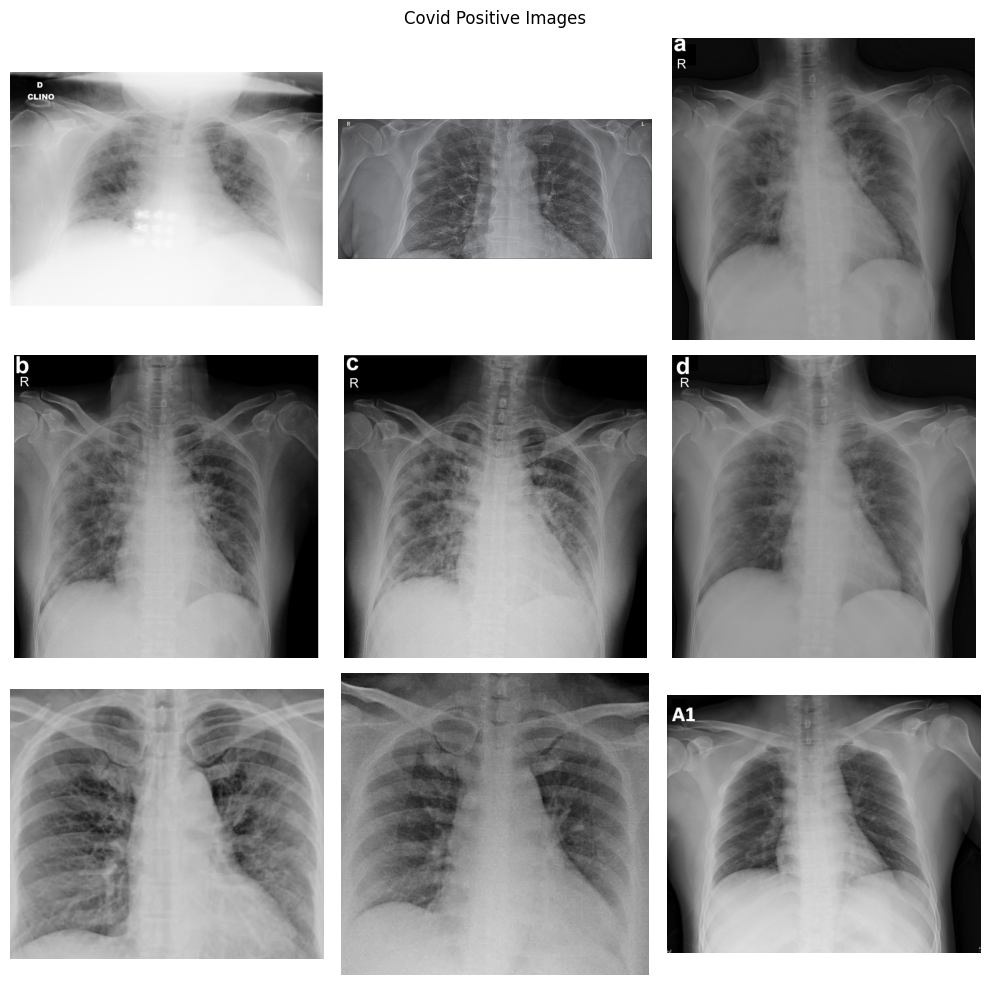

In [34]:
covids = list(data_dir.glob('covid/*'))
fig, axs = plt.subplots(3,3, figsize=(10,10))

for i in range(9):
    img = PIL.Image.open(str(covids[i]))

    row = i // 3
    col = i % 3

    axs[row, col].imshow(img)
    axs[row, col].axis('off')

fig.suptitle('Covid Positive Images')
plt.tight_layout()
plt.show()

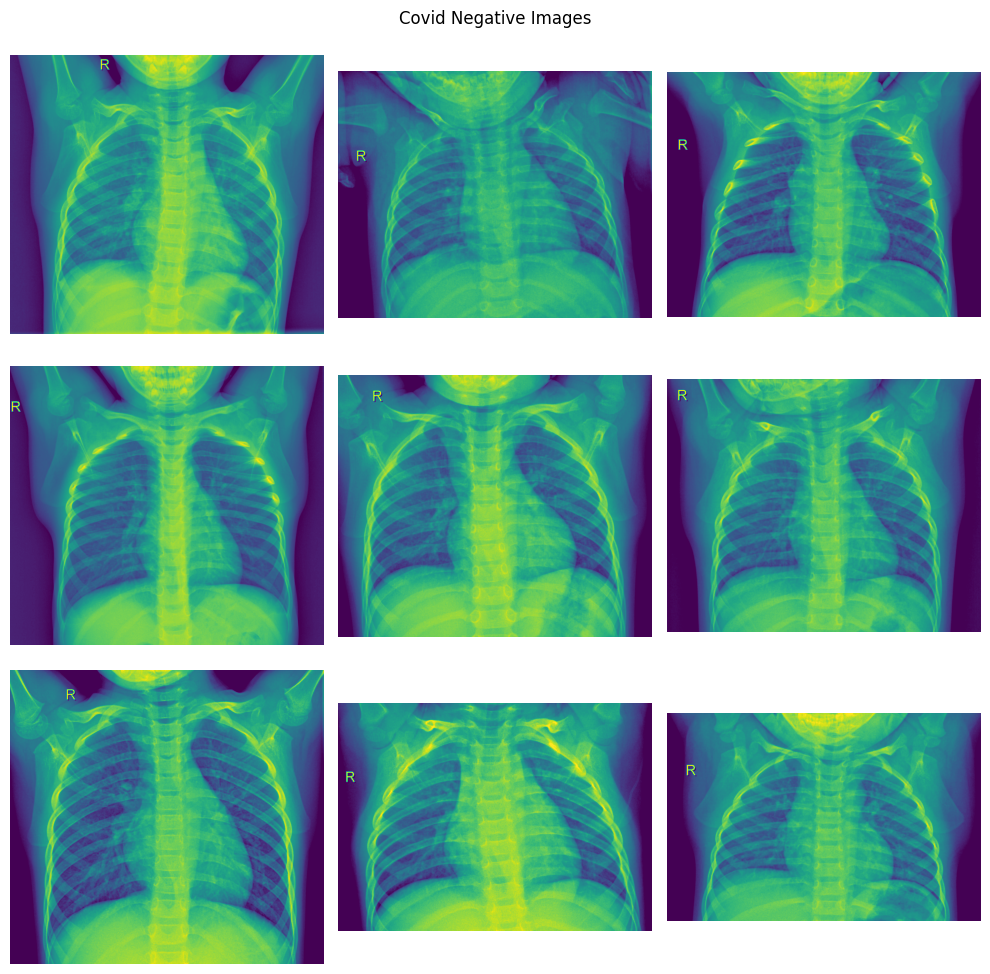

In [35]:
normals = list(data_dir.glob('normal/*'))
fig, axs = plt.subplots(3,3, figsize=(10,10))

for i in range(9):
    img = PIL.Image.open(str(normals[i]))

    row = i // 3
    col = i % 3

    axs[row, col].imshow(img)
    axs[row, col].axis('off')

fig.suptitle('Covid Negative Images')
plt.tight_layout()
plt.show()